Copyright © 2025 Technical University of Denmark

In [1]:
from os import chdir
chdir('../')

In [2]:
from lcg_plus.base import State
from lcg_plus.conversions import r_to_dB, dB_to_r, Delta_to_dB, dB_to_Delta
from thewalrus.symplectic import squeezing
from lcg_plus.effective_sqz import effective_sqz
import numpy as np
from copy import deepcopy
from lcg_plus.plotting import plot_wig
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from catprep import get_input_sq_cat
hbar = 2

from thewalrus.symplectic import beam_splitter, xxpp_to_xpxp

In [3]:
num = 3
N = 200
r_dB = -12
parity = 0
which = 'square'
eta = 1

ps = np.linspace(-1.5,1.5,N)*np.sqrt(2*np.pi*hbar) 

cat = get_input_sq_cat(num, r_dB, parity, which, eta)
mu = cat.means[0][0]
print(mu)

(3.069980123839465+0j)


In [4]:
def sim_breeding_circuit(N, num, r_dB, parity, which, eta, phis, results, out = False, bs_thetas = False):
    """Simulate the breeding of cats with different parities
    """
    rho0 = get_input_sq_cat(num[0], r_dB[0], parity[0], which[0], eta[0])
    
    multistate = deepcopy(rho0)
    multistate.get_norm()
    norms = np.zeros(N)
    norms[0] = multistate.norm
        
    if out:
        print('Input data shape', multistate.means.shape, multistate.covs.shape, multistate.weights.shape)
        print('norm', multistate.norm)
    
    for i in range(1,N):
        rhoi = get_input_sq_cat(num[i], r_dB[i], parity[i], which[i], eta[i])
        rhoi.get_norm()
        norms[i] = rhoi.norm
        multistate.add_state(rhoi)
        
        if out:
            print('norm', multistate.norm)
        #if rot == True:
            #R = xxpp_to_xpxp(expand(rotation(np.pi),1,2)) #Rotate the 2nd mode by 180 degrees
            #multistate.apply_symplectic(R)
        if out:
            print('newstate shape', multistate.means.shape, multistate.covs.shape, multistate.weights.shape)

        #Apply custom beamsplitters if given
        if bs_thetas:
            S = beam_splitter(bs_thetas[i-1][0],bs_thetas[i-1][1])
            if out:
                print(f'Applying BS({bs_thetas[i-1][0]}{bs_thetas[i-1][1]}) on modes {i-1},{i}')
        #Apply 
        else:
            #Apply beam splitter
            S = beam_splitter(np.arccos(np.sqrt(1/(1+i))),0)
            if out:
                print(f'Applying BS({np.arccos(np.sqrt(1/(1+i)))} on modes {i-1},{i}')

        multistate.apply_symplectic(xxpp_to_xpxp(S))
        
        if out:
            print('num_k', multistate.num_k, 'num_weights', multistate.num_weights, 'norm', multistate.norm)
       
        multistate.post_select_homodyne(0, phis[i-1], results[i-1])
        
          
        if out:
            print(f'Measure p={results[i-1]} on mode {i-1} with conditional prob {multistate.norm/n1**i}')
    
        #Reduce
    
        multistate.reduce_equal_means()
        multistate.get_norm()
        
        if out:
            print('new no. of weights: ', multistate.num_weights)
            print('norm', multistate.norm)
    
    return multistate, multistate.norm/np.prod(norms)

In [5]:
## Simulate breeding of cats with different parities for a grid of p outcomes

N = 3
r = -12

num = np.repeat(N,N)
r_dB = np.repeat(r,N)
eta = np.repeat(1,N)
which = np.repeat('square', N)
parity = np.array([0,1,0])

m = 200
ps = np.linspace(-1.5,1.5,m)*np.sqrt(2*np.pi*hbar) 
#ps = np.linspace(-4,4,m)*np.sqrt(2*np.pi*hbar) 
probs = np.zeros((m,m))
Dp = np.zeros((m,m))

for i, p1 in enumerate(ps):
    for j, p2 in enumerate(ps):
        out, prob = sim_breeding_circuit(N, num, r_dB, parity, which, eta, np.ones(N-1)*np.pi/2, np.array([p1,p2]))
        #Dx[i,j] = effective_sqz(out, 'rx')
        Dp[i,j] = effective_sqz(out, 'sp')

        probs[i,j] = prob



In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

cmap = sns.color_palette("hls", n_colors = 8)
c = cmap[1]

c  = 'w'

def plot_grid(ax, grid, c =c,s= 2):
    
    a = hbar * np.pi/2/(mu*np.sqrt(2))
    b = hbar*np.pi/2 / (2*np.sqrt(2/3)*mu)
    d = np.sqrt(a**2 + b**2)
    
    phases = np.array([0,np.pi/3, 2*np.pi/3, np.pi, 4*np.pi/3, 5*np.pi/3])
    ds = d*np.exp(1j*phases)
    
    kwargs = {'c': c, 's': s}
    for d in ds:
        ax.scatter(d.real/grid,d.imag/grid, **kwargs)
   
def plot_cbar(ax, im, label = None):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax = cax, label = label)
    

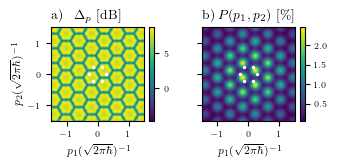

In [7]:
hbar = 2
colwidth = 3.41667

mpl.rcParams.update({'font.size': 8, 
                     "text.usetex": True, 
                     'font.family':'serif', 
                     'xtick.labelsize': 6, 
                     'ytick.labelsize':6})

cmap = sns.color_palette('viridis', as_cmap = True)

fig, (ax1,ax2) = plt.subplots(1,2, sharex = True, sharey = True, figsize=(colwidth,colwidth))
grid = np.sqrt(2*np.pi*hbar)
extent = [np.min(ps), np.max(ps), np.min(ps), np.max(ps)]/grid 
im1 = ax1.imshow(Delta_to_dB(Dp.T), extent = extent, cmap = cmap)
ax1.set_title(r'$\Delta_p$ [dB]')
ax1.set_title(r'a)', loc = 'left')
plot_cbar(ax1, im1)
plot_grid(ax1, grid)


im2 = ax2.imshow(probs.T*100, extent = extent,  cmap = cmap)
ax2.set_title(r'$P(p_1,p_2)$ [\%]', loc = 'right')
ax2.set_title(r'b)', loc = 'left')
plot_cbar(ax2, im2)
plot_grid(ax2, grid)


ax1.set_ylabel(r'$p_2(\sqrt{2\pi\hbar})^{-1}$')
ax2.set_xlabel(r'$p_1(\sqrt{2\pi\hbar})^{-1}$')
ax1.set_xlabel(r'$p_1(\sqrt{2\pi\hbar})^{-1}$')
plt.tight_layout()
plt.savefig('figures/N=3_p1p2_parity_010.pdf', dpi = 800,  bbox_inches='tight')
plt.show()
